# Creating an Interactive Executable Circuit Model of the Lamina Cartridge

In this tutorial we walk through an eample of creating an interactive executable circuit model of the lamina cartridge. The starting point of the example is the connectomic data of a lamina cartridge. Through the example, we will highlight core FlyBrainLab capabilities to load data, to query and analyze data, to create interactive circuit diagram and to execute the resulting circuit.

Before we begin, make sure you have the following set up in the backend servers.
- Assuming that you have already started FlyBrainLab, you will need to create a new NeuroArch server by
```
ffbo/bin/run_neuroarch.sh -b lamina -s lamina -m o
```
The option `-m o` will overwrite any existing database folder `lamina` and create a new writable one. If you run into issues below and mess up with the database, you can always run the above command to restart fresh. If you do not need to overwrite the database, just `-m w` to open it in writable model.

- Then create a new NLP server by reusing medulla app that will give you some basic query capabilities
```
ffbo/bin/run_nlp.sh -a medulla -s lamina
```
- Finally, create a adult(lamina) workspace. Configure a new type of FlyBrainLab Workspace with the configuration as displayed below.
![processor_Setup](processor_setup.jpg)


In [ ]:
import flybrainlab as fbl
import flybrainlab.query as fbl_query
import flybrainlab.circuit as circuit
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# acquire the client object and make sure that the widgets are associated with the client.
client = fbl.get_client()
for i in fbl.widget_manager.widgets:
    if fbl.widget_manager.widgets[i].widget_id not in\
            fbl.client_manager.clients[
                 fbl.widget_manager.widgets[i].client_id
             ]['widgets']:
        fbl.client_manager.clients[
            fbl.widget_manager.widgets[i].client_id
            ]['widgets'].append(
                fbl.widget_manager.widgets[i].widget_id)

## Loading connectome data into the NeuroArch database

Data can be loaded into NeuroArch database from the FlyBrainLab frontend by using the NeuroArch_Mirror class that mirros the high-level NeuroArch API.

In [ ]:
db = fbl_query.NeuroArch_Mirror(client)

Create a species:

In [ ]:
species=db.add_Species('Drosophila melanogaster',
                       stage = 'adult',
                       sex = 'female',
                       synonyms = [
                               'fruit fly',
                               'common fruit fly',
                               'vinegar fly'
                        ])

Create a data source:

In [ ]:
data_source = db.add_DataSource(
                'cartridge', 
                version = '1.0',
                url = '',
                description = 'Rivera-Alba et al.,\
                               Current Biology 2011',
                species = list(species.keys())[0])

Make the above data source default.

In [ ]:
db.select_DataSource(list(data_source.keys())[0])

[FBL NA 2022-11-14 14:06:49,156] Default datasource set


Add the lamina neuropil.

In [ ]:
lam = db.add_Neuropil('LAM(L)', 
                      synonyms = ['left lamina'])

Reading neuron data

In [ ]:
def load_swc(file_name):
    df = pd.read_csv(file_name, 
                     sep = ' ',
                     header = None,
                     comment = '#',
                     index_col = False,
                     names = [
                         'sample', 'identifier',
                         'x', 'y', 'z', 'r', 'parent'],
                    skipinitialspace = True)
    return df

neuron_list = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6',
               'L1', 'L2', 'L3', 'L4', 'L5', 'T1',
               'a1', 'a2', 'a3', 'a4', 'a5', 'a6',
               'C2', 'C3']
swc_dir = 'swc'

Reading synapse data

In [ ]:
connections = pd.read_csv('connection.csv', index_col = 0)
neuron_order = connections.columns.to_list()
adjacency = connections.to_numpy()

Loading Neuron data into database

In [ ]:
for neuron in neuron_list:
    df = load_swc('{}/{}.swc'.format(swc_dir, neuron))
    morphology = {'x': (df['x']*0.04).tolist(),
                  'y': (df['y']*0.04).tolist(),
                  'z': (df['z']*0.04).tolist(),
                  'r': (df['r']*0.04).tolist(),
                  'parent': df['parent'].tolist(),
                  'identifier': [0]*(len(df['x'])),
                  'sample': df['sample'].tolist(),
                  'type': 'swc'}

    arborization = []
    arborization.append(
        {'type': 'neuropil',
         'dendrites': {
                'LAM(L)': int(connections.loc[neuron].sum())},
         'axons': {
                 'LAM(L)': int(connections[neuron].sum())}
         })
    db.add_Neuron(neuron, # uname
                  neuron, # name
                  referenceId = neuron, #referenceId
                  morphology = morphology,
                  arborization = arborization)

In [ ]:
db.flush_edges()

Loading synapse data into database

In [ ]:
for post_ind, pre_ind in zip(*np.nonzero(adjacency)):
    pre_neuron = neuron_order[pre_ind] 
    post_neuron = neuron_order[post_ind]
    db.add_Synapse(pre_neuron, post_neuron, int(adjacency[post_ind][pre_ind]))

## Builidng and exploring cartridge pathway

In [ ]:
# query to get all the neurons since we have only a few
res1 = client.executeNLPquery('show all')

[FBL NLP 2022-11-14 14:18:02,550] NLP successfully parsed query.


Obtaining the connectivity matrix between neurons

[twisted 2022-11-14 14:18:04,480] /home/ffbo/ffbo/FBLClient/flybrainlab/graph.py:364: builtins.FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


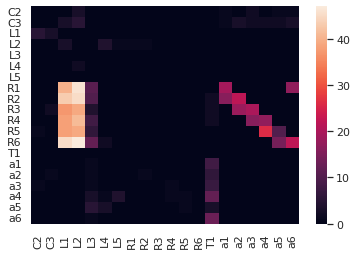

In [ ]:
g = client.get_neuron_graph(synapse_threshold = 0)
M, order = g.adjacency_matrix()
sns.heatmap(M, xticklabels = order, yticklabels = order);

## Interactive exploration of the circuit diagram

Next we interactively build an executable cirucit using a circuit diagram manually created based on the connectivity above. We construct an `ExecutableCircuit` object from the NLP query result above. In this case, there is no model associated with these neurons yet. It initializes a new executable circuit.

In [ ]:
c = circuit.ExecutableCircuit(client, res1, model_name = 'cartridge', model_version = '1.0')

Model with name cartridge version 1.0 does not exist.                            Initializing a new executable circuit


In [ ]:
c.initialize_diagram_config(no_send=True)

Load a SVG circuit diagram manually created and make it interactive through injecting a piece of standardized JavaScript code into the GFX window.

In [ ]:
diagram = 'cartridge.svg'
jsfilename = 'onCartridgeLoad.js'

c.load_submodule(jsfilename, primary = True, name = 'cartridge')
c.load_diagram(diagram, primary = True, name = 'cartridge', display = True)

sending circuit configuration to GFX


Now we can interact with the diagram to highlight a neuron and its connected neurons, choose the model implementation for each of the cells by right clicking on it, single click to slience/rescue the neuron. For example, right clicking on R1 in the NeuroGFX window and choose PhotoreceptorModel as its model.

The same model can be populated to other photoreceptors R2-R6 by

In [ ]:
c.update_model_like(['R{}'.format(i) for i in range(2,7)], 'R1')

sending circuit configuration to GFX


repeat this for other neurons but use the MorrisLecarNonSpiking model

In [ ]:
c.update_model('L2', {'V1': -20.0,
                      'V2': 50.0,
                      'V3': -40.0,
                      'V4': 20.0,
                      'phi': 0.1,
                      'offset': 0.0,
                      'V_L': -40.,
                      'V_Ca': 80.0,
                      'V_K': -80.0,
                      'g_L': 15.0,
                      'g_Ca': 2.0,
                      'g_K': 10.,
                      'name': 'MorrisLecar'},
                states = {'V': -46.08, 'n': 0.3525})

c.update_model_like(['L1', 'L3', 'L4', 'L5', 'T1', 
                     'C2', 'C3', 'a1', 'a2', 'a3',
                     'a4', 'a5', 'a6'],
                    'L2')

sending circuit configuration to GFX
sending circuit configuration to GFX


Now we get all the synapses in the circuit

In [ ]:
update_models = {}
for rid, v in c.get('Synapse').items():
    update_models[v['uname']] = {
        'params': {'name': 'SigmoidSynapse',
                    'reverse': -80.0 if \
                               v['uname'].split('--')[0][0] == 'R'\
                               else 0,
                   'threshold': -50.5,
                    'slope': 0.05,
                    'gmax': 0.04,
                    'scale': c.graph.nodes[rid]['N']
                   },
         'states': {'g': 0.0}}
c.update_models(update_models)


sending circuit configuration to GFX


Write the created model to database with name cartridge and version 1.0.

In [ ]:
c.flush_model()

## Execution of the model circuit on Neurokernel Execution Engine.

In [ ]:
res = c.remove_components()

Define the duration and time step of simulation

In [ ]:
dur = 2.0
dt = 1e-4
steps = int(dur/dt)

Define input to the circuit. Here we prsent a Step input from time
0.5s to 1.5s at the brightness level equivalent to 10,000 photons per second, to the 6 photoreceptors. We also specify if you want to return the sensory inputs to the neurons.

In [ ]:
input_processors = {'LAM(L)': 
      [{'class': 'StepInputProcessor',
        'name': 'LAM(L)',
        'module': 'neurokernel.LPU.InputProcessors.StepInputProcessor',
        'variable': 'photon',
        'uids': [c.find_model(c.uname_to_rid['R{}'.format(i)]).popitem()[0] for i in range(1,7)],
        'val': 1e4,
        'start': 0.5,
        'stop': 1.5,
        'input_file': 'LAM_input.h5',
        'input_interval': 10}
       ]}

Choose to record response of the circuit with the "Record" class and specify the variables and components to record.

In [ ]:
output_processors = {'LAM(L)':
      [{'class': 'Record',
        'uid_dict': {'V': {'uids': None}},
        'sample_interval': 10}
       ]}

Run the model. Several things take place under the hood. First, the executable circuit is written to the database. Second, the disabled neurons will be processed and removed from the circuit. Third, the circuit will run under the input_processor and return back the result.

In [ ]:
c.execute(input_processors = input_processors,
          output_processors = output_processors,
          steps = steps, dt = dt)

[FBL NK 2022-11-14 14:22:41,024] Execution request sent. Please wait.
[FBL NK 2022-11-14 14:22:41,025] Job received. Currently queued #1
[FBL GFX 2022-11-14 14:23:00,919] Receiving Execution Result for cartridge/1.0.  Please wait .....
[FBL GFX 2022-11-14 14:23:01,026] Received Execution Result for cartridge/1.0. Result stored in Client.exec_result['cartridge/1.0']


After waiting till the message suggesting the response is ready, the result will be reorganized to be refereed to using names of the neurons/synapses.

In [ ]:
result = c.get_result('cartridge/1.0')

Plot responses.

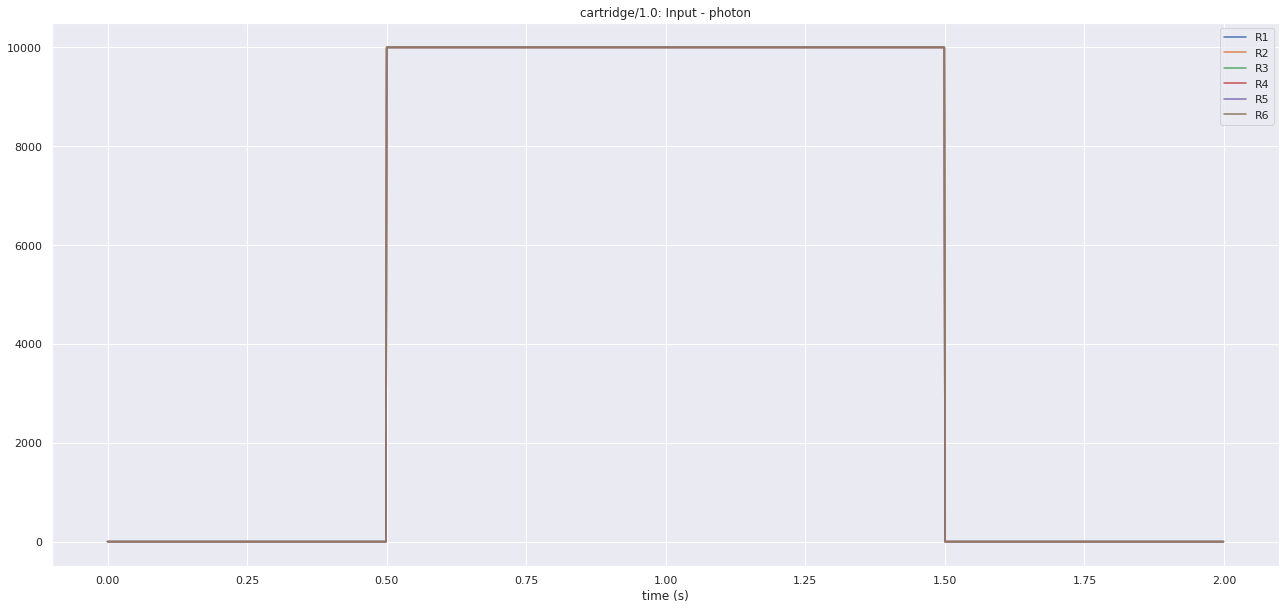

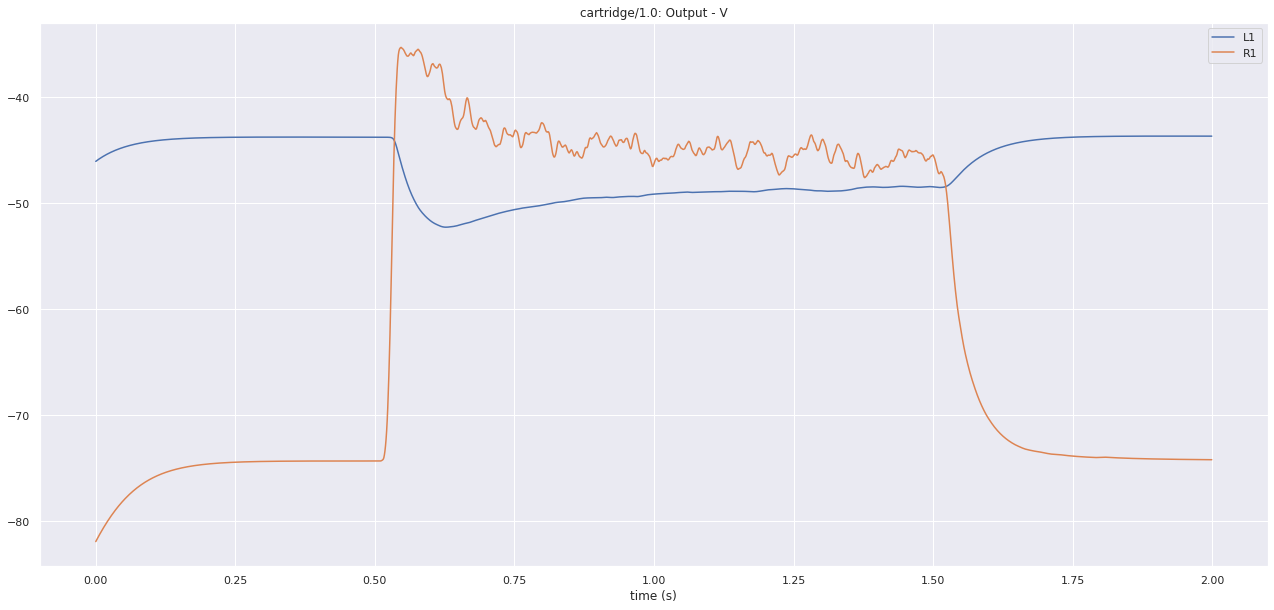

In [ ]:
client.plotExecResult('cartridge/1.0', outputs = ['R1', 'L1'])

## Retrieving Executable Circuit from Database for Execution

Now let's clear the workspace and fire the same NLP query as before.

In [ ]:
res1 = client.executeNLPquery('show all')

[FBL NLP 2022-11-14 14:23:46,049] NLP successfully parsed query.


This time we can retrieve the executable circuit from the database that we just wrote, using the same methods as before

In [ ]:
c = circuit.ExecutableCircuit(client, res1)

Please select from the exisiting models to initialize the executable circuit, or press a to abort
0: cartridge version 1.0 (rid #506:0) 0


#506:0
sending circuit configuration to GFX


We wree asked to choose from a list of executable circuits that models the circuit displayed in the NeuronLP window. Here only one such model exists, which is the one we created before.

This time we disable R2-R6, a1-a6, L3 and T1 neurons on the circuit diagram. Equivalently, we can issue the following command:

In [ ]:
c.disable_neurons(['R{}'.format(i) for i in range(2, 7)] + \
                  ['a{}'.format(i) for i in range(1, 7)] + \
                  ['L3', 'T1'])

sending circuit configuration to GFX


and then reflect this change in the database before executng it.

In [ ]:
res = c.remove_components()

In [ ]:
dur = 2.0
dt = 1e-4
steps = int(dur/dt)

input_processors = {'LAM(L)': 
     [{'class': 'StepInputProcessor',
       'name': 'LAM(L)',
       'module': 'neurokernel.LPU.InputProcessors.StepInputProcessor',
       'variable': 'photon',
       'uids': [c.find_model(c.uname_to_rid['R1']).popitem()[0]],
       'val': 1e4,
       'start': 0.5,
       'stop': 1.5,
       'input_file': 'LAM_input.h5',
       'input_interval': 10}
     ]}
output_processors = {'LAM(L)':
      [{'class': 'Record',
        'uid_dict': {'V': {'uids': None}},
        'sample_interval': 10}
     ]}

In [ ]:
c.execute(input_processors = input_processors,
      output_processors = output_processors,
      steps = steps, dt = dt)

[FBL NK 2022-11-14 14:24:08,204] Execution request sent. Please wait.
[FBL NK 2022-11-14 14:24:08,205] Job received. Currently queued #1
[FBL GFX 2022-11-14 14:24:22,987] Receiving Execution Result for cartridge/1.0.  Please wait .....
[FBL GFX 2022-11-14 14:24:23,014] Received Execution Result for cartridge/1.0. Result stored in Client.exec_result['cartridge/1.0']


In [ ]:
result = c.get_result('cartridge/1.0')

Finally, we plot the input to R1 and the responses of R1 and L1, where L1 only receives input from 1 photoreceptor as compared to 6 in the previous execution.

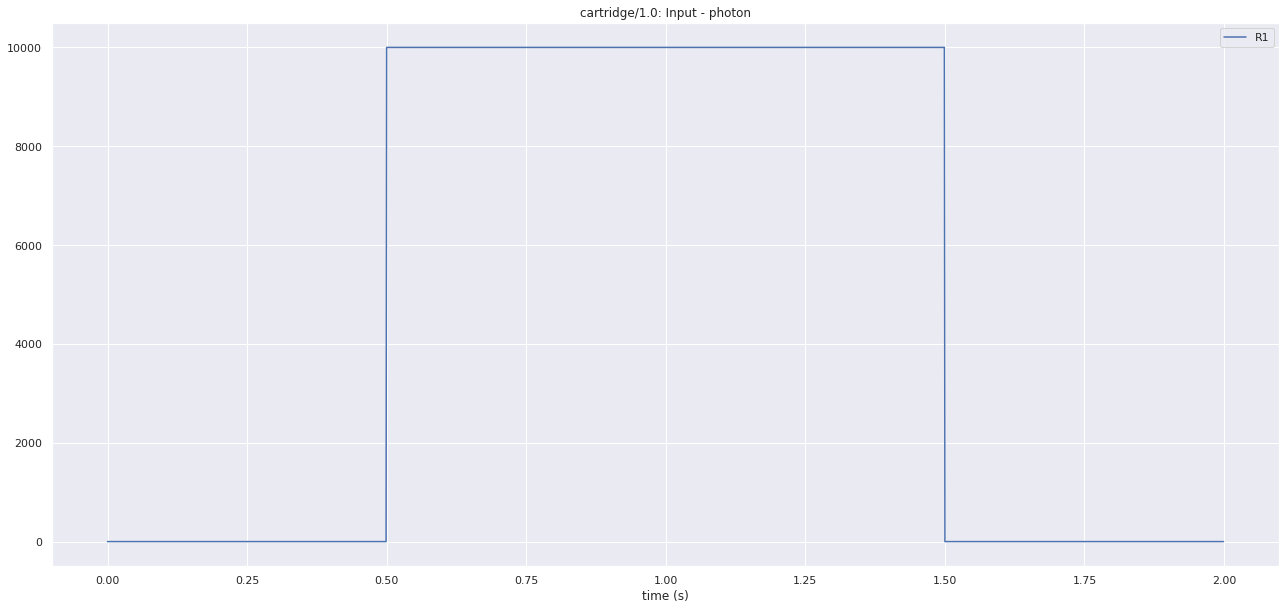

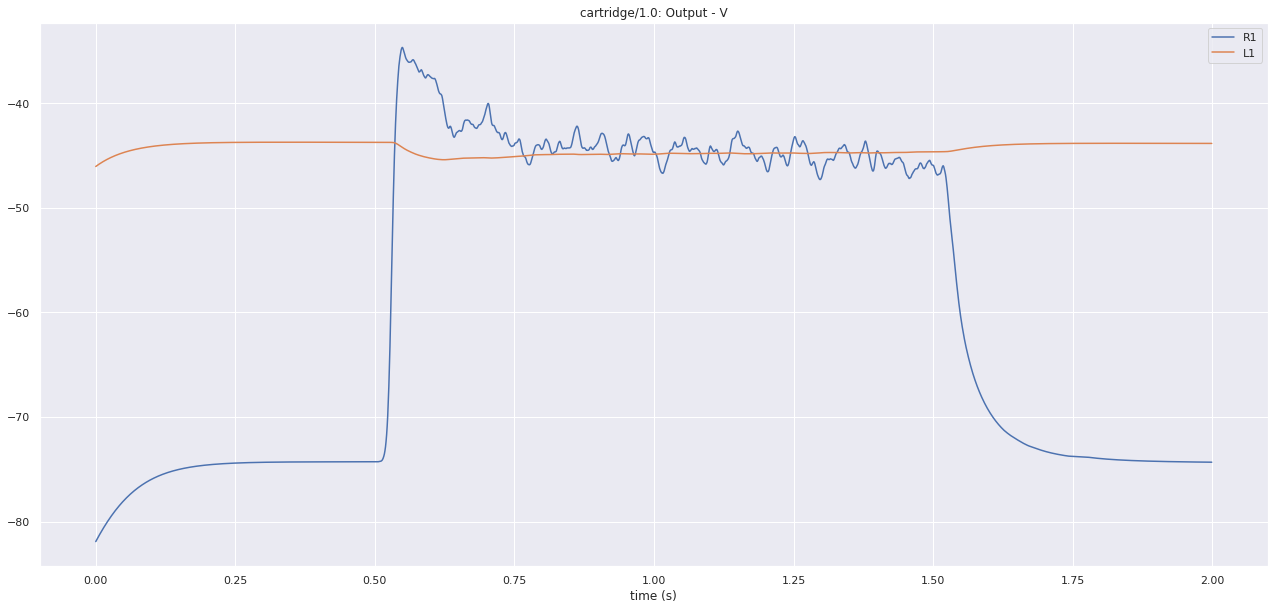

In [ ]:
client.plotExecResult('cartridge/1.0', outputs = ['R1', 'L1'])